<a href="https://colab.research.google.com/github/JaiTheGuy/CMP414-765_Spring2020/blob/master/Final_Project_(Dutch_Translation_Modification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/mount')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/mount


In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [0]:
path_to_file = "/content/mount/My Drive/Colab Notebooks/nld.txt"

import os
#print(os.listdir("/content/mount/My Drive/Colab Notebooks/"))



In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  w = re.sub(r"[^a-zA-Z?.!,]+", " ", w)
  w = w.strip()
  w = '<start> ' + w + ' <end>'
  return w


In [7]:
en_sentence = u"That's a blue house."
dt_sentence = u"Dat is een blauw huis."
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(dt_sentence).encode('utf-8'))

<start> that s a blue house . <end>
b'<start> dat is een blauw huis . <end>'


In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, DUTCH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  print(lines[1])

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')][:2]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [9]:
en, dh = create_dataset(path_to_file, None)
print(en[-1])
print(dh[-1])

Hi.	Hé!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #6117419 (Raizin)
<start> if someone who doesn t know your background says that you sound like a native speaker , it means they probably noticed something about your speaking that made them realize you weren t a native speaker . in other words , you don t really sound like a native speaker . <end>
<start> als iemand die je achtergrond niet kent zegt dat je klinkt als een moedertaalspreker betekent dat dat diegene waarschijnlijk iets in je spreken opgemerkt heeft dat hem deed realiseren dat je geen moedertaalspreker bent . met andere woorden , je klinkt niet echt als een moedertaalspreker . <end>


In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [12]:
num_examples = 20000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

Hi.	Hé!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #6117419 (Raizin)


In [13]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

16000 16000 4000 4000


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [15]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> ik
44 ----> wil
9 ----> een
419 ----> biertje
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
40 ----> want
9 ----> a
165 ----> beer
3 ----> .
2 ----> <end>


In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [17]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [19]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [21]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x)

    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    output, state = self.gru(x)

    output = tf.reshape(output, (-1, output.shape[2]))

    x = self.fc(output)

    return x, state, attention_weights

In [23]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4103)


In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [27]:
EPOCHS = 5

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6794
Epoch 1 Batch 100 Loss 2.1822
Epoch 1 Batch 200 Loss 2.0219
Epoch 1 Loss 2.2531
Time taken for 1 epoch 845.4219238758087 sec

Epoch 2 Batch 0 Loss 1.8351
Epoch 2 Batch 100 Loss 1.4793
Epoch 2 Batch 200 Loss 1.4184
Epoch 2 Loss 1.5498
Time taken for 1 epoch 811.1050264835358 sec

Epoch 3 Batch 0 Loss 1.3879
Epoch 3 Batch 100 Loss 1.2527
Epoch 3 Batch 200 Loss 1.1099
Epoch 3 Loss 1.2102
Time taken for 1 epoch 855.4519670009613 sec

Epoch 4 Batch 0 Loss 0.9786
Epoch 4 Batch 100 Loss 0.9408
Epoch 4 Batch 200 Loss 0.8529
Epoch 4 Loss 0.9147
Time taken for 1 epoch 875.6977660655975 sec

Epoch 5 Batch 0 Loss 0.6650
Epoch 5 Batch 100 Loss 0.6644
Epoch 5 Batch 200 Loss 0.6677
Epoch 5 Loss 0.6612
Time taken for 1 epoch 923.7620632648468 sec

Epoch 6 Batch 0 Loss 0.4327
Epoch 6 Batch 100 Loss 0.4631
Epoch 6 Batch 200 Loss 0.4455
Epoch 6 Loss 0.4577
Time taken for 1 epoch 818.8321979045868 sec

Epoch 7 Batch 0 Loss 0.2947
Epoch 7 Batch 100 Loss 0.2849
Epoch 7 Batch 200 

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [31]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> tom zal je betalen . <end>
Predicted translation: tom will pay you . <end> 


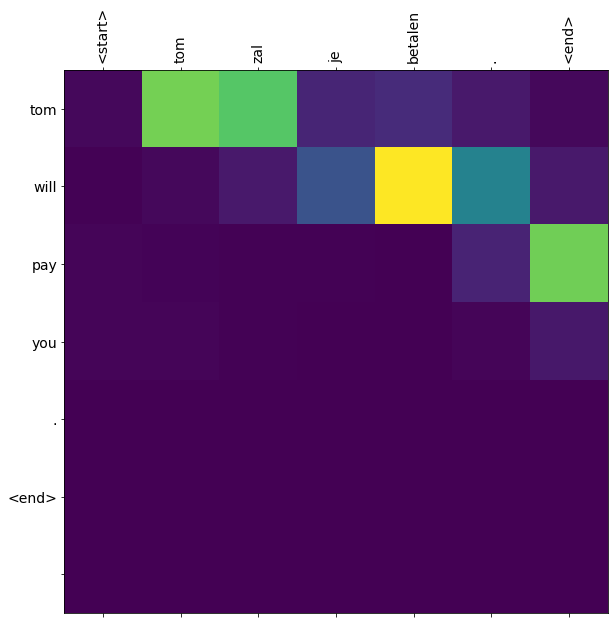

In [35]:
translate(u'Tom zal je betalen.')

Input: <start> de soep is koud . <end>
Predicted translation: the soup is cold . <end> 


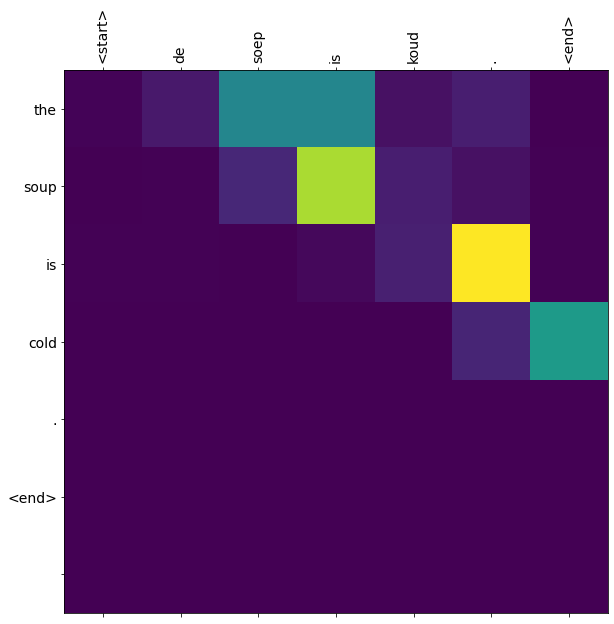

In [36]:
translate("De soep is koud.")